In [1]:
import cPickle as pickle
from io import open
import pandas as pd
import numpy as np
import pytz
from types import StringType

In [2]:
import datetime
from datetime import date, datetime
import dateutil
from dateutil import parser

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
from mpltools import style
style.use("ggplot")

### Loading Data

In [5]:
fh = open("/data/csc/fb_persons/unified_100percentpeople.pkl", "rb")
df = pickle.load(fh)

In [6]:
len(df)

3379996

In [7]:
df.head()

,date_of_birth,ethnicity,gender,name,nationality,place_of_birth,profession,religion
0,NaN,None,Female,Courtney Jamieson,None,NaN,music_art,None
1,NaN,None,Male,Robert Moir,None,NaN,other,None
2,1962-04-21,None,Male,Mehdi Jomaa,middle eastern,Mahdia,"(law_politics, stem)",None
3,NaN,None,Male,Victoria Shields,None,NaN,None,None
4,1992-06-24,None,Male,Terrick Colston,None,NaN,None,None


### Considering only people after 1800s

In [8]:
victorian_age = date(1800, 1, 1)
df = df[np.logical_not(df.date_of_birth.isnull().values)]
df = df[df.date_of_birth > victorian_age]

In [9]:
len(df)

1300159

### Cleaning Nationalities

In [10]:
def replace_nationality(x):
  if not x: return np.nan
  USA = "USA"
  if isinstance(x, StringType) and x.lower() == "united states of america":
    return USA
  if isinstance(x, tuple):
    nationalities = set([y.lower() for y in x])
    usa = "united states of america"
    if usa in nationalities:
      nationalities = nationalities.difference([usa])
      nationalities.add(USA)
    return tuple(nationalities)

In [11]:
df["nationality"] = df.nationality.apply(func=lambda x: replace_nationality(x))

### Considering Only Americans

In [12]:
americans = map(lambda x: (isinstance(x, StringType) and x == 'USA') or 
                          (isinstance(x, tuple) and  'USA' in x),
                          df.nationality)
df = df[americans]

In [13]:
#rows = np.random.choice(df.index.values, 1000000)
sample = df

In [14]:
def remove_USA(x):
  if not x: return np.nan
  USA = "USA"
  if isinstance(x, StringType) and x.lower() == USA:
    return np.nan
  if isinstance(x, tuple):
    nationalities = set(x)
    if USA in nationalities:
      nationalities = nationalities.difference([USA])
      if not nationalities: return np.nan
    if len(nationalities) == 1: return list(nationalities)[0]
    return tuple(nationalities)

In [15]:
df["nationality"] = df.nationality.apply(func=lambda x: remove_USA(x))

### Attribute Distribution

In [37]:
def dist_plot(field):
  fig = plt.figure()
  s = sample[field]  
  total = len(s)
  g = s.dropna()
  left = len(g)
  percentage = 100.0 * left / total
  ax = g.value_counts(normalize=True, dropna=True)[:10].plot(kind="bar",  title=field)
  ax.set_xlabel("{:.1f}% of the {} data is available".format(percentage, field))

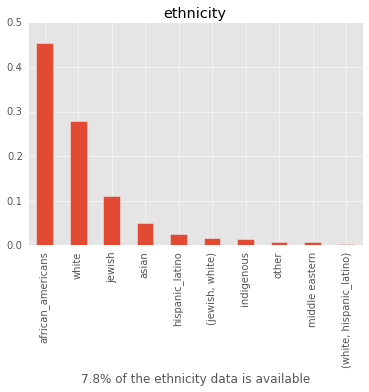

In [40]:
fields1 = ["religion", "ethnicity", "profession", "gender"]
_ = interact(dist_plot,
         field=RadioButtons(options=zip(fields1, fields1)))

## Temporal Attribute Evolution

In [31]:
from IPython.html.widgets import (interact, RadioButtons, IntSliderWidget, TextWidget,
                                  DropdownWidget, Dropdown, Select)
from IPython.display import display

In [19]:
def temporal(df, field, resolution=10, nan_included=False, start=None, end=None):
  df = df[np.logical_not(df.date_of_birth.isnull().values)]
  df = df[df.date_of_birth > start]
  df = df[df.date_of_birth < end]    
  if nan_included: 
    bla = df[[field]].fillna("nan")
  else:
    bla = df[[field]]
  bla.index = [datetime(d.year, d.month, d.day) if d < date(2015, 1, 1) else pd.NaT
               for d in df.date_of_birth.values]
  year_grouped = bla.groupby([(bla.index.year//resolution)*resolution, field])
  counted = year_grouped.agg(len)
  counted = counted.reset_index(level=1)
  counted = counted.rename(columns={0:"count"})
  counted.index = [datetime(int(y), 1, 1) for y in counted.index]
  final = counted.pivot_table(index=counted.index, values="count", columns=[field])
  final = final.fillna(0)
  final = final[np.logical_not(final.index.isin([pd.NaT]))]
  norm_final = final.div(final.sum(axis=1), axis=0)
  return final, norm_final

In [51]:
def temporal_plot(f, plot_type, start_year, resolution, end_year):
  start = date(start_year, 1, 1)
  end = date(end_year, 1, 1)
  df1, df2 = temporal(sample, f, nan_included=False, resolution=resolution, start=start, end=end)
  totals = df1.sum().values
  percentages = totals / float(sum(totals))
  selected_cols = df1.columns[np.argsort(percentages).flatten()[-6:]].values  
  ax1 = df1[selected_cols].plot(kind=plot_type, title="Counts of {}".format(f))
  ax1.legend(loc='upper right', ncol=2, bbox_to_anchor = (2.0, 1.0))
  ax2 = df2[selected_cols].plot(kind=plot_type, title="Normalized Counts of {}".format(f))
  ax2.legend(loc='upper right', ncol=2, bbox_to_anchor = (2.0, 1.0))

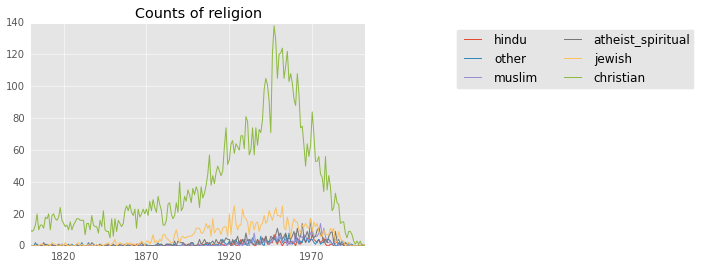

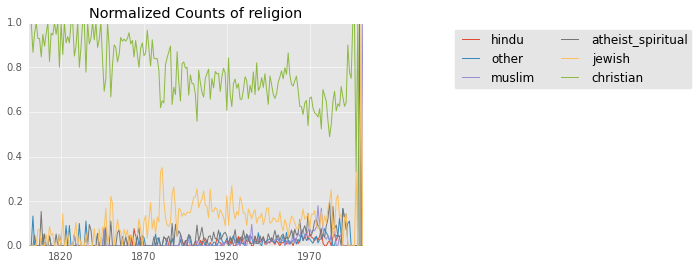

In [50]:
fields = ["religion", "ethnicity", "profession", "gender"]
_ = interact(temporal_plot,
         f=RadioButtons(options=zip(fields, fields)),
         plot_type=Select(options={"area": "area", "line": "line"}),
         start_year=IntSliderWidget(min=1800, max=2010, step=10, value=1800),
         end_year=IntSliderWidget(min=1800, max=2010, step=10, value=2010),
         resolution=IntSliderWidget(min=0, max=50, step=5,value=1),
        )